# TODO:
- Add something to add a minimap to the delta_twtt plot to show one point in the general area of the crossover points for quick reference
    - or add a plot to the side which displays the continent and a "you are here" star marker IVO the crossover points
- **Implement multi flight crossover point finding**
- Multi flight plotting
    - how many flights could I put in a file together? i.e. can I save a full season to one file in the pickle format?
- scaling for overall depth in twtt? i.e. less effect in shallower ice so you can't really compare to deeper ice CX points



In [1]:
import matplotlib.pyplot as plt
import os
from project_classes import *
from functions import *
from iceflow_library import *
from scipy.optimize import curve_fit
import scipy.optimize as opt

In [2]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8" 
season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
# season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
    # that flight only has one point
# flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
    # one dimensional data error
    # TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
    # plots fake crossovers along the curved path
# flight = "20161024_05"
flight = "20161111_05"
    # probably too close to the coast to be useful
# flight = "20161024_05"
# flight = "20141026_06"
    # this one is 1/3 of an orbit and produces a bunch of bunk crossovers
# flight = "20230127_01"
    # ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

In [3]:
"""
read in the layers from the layer files and save them to a pickle file
"""
force = True

if not force:
    if not os.path.isfile(file_name):  # if the file does not exist
        print(f"File {file_name} does not exist. Making it...")
        mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
        layers = read_layers(file_name)  # read in the layers from the pickle file
        print(f"File {file_name} created.")
    else:
        layers = read_layers(file_name)  # read in the layers from the pickle file
        print(f"File {file_name} loaded.")
else:
    mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
    layers = read_layers(file_name)  # read in the layers from the pickle file

Reading data files...
--------------------
data_file: C:\Users\rj\Documents\cresis\rds\2016_Antarctica_DC8\CSARP_layer\20161111_05\Data_20161111_05_
filled_data_file: C:\Users\rj\Documents\cresis\rds\2016_Antarctica_DC8\CSARP_layer\20161111_05\Data_20161111_05_001.mat
f['param']: <HDF5 group "/param" (6 members)>
f['param'].keys(): ['day_seg', 'radar', 'radar_name', 'records', 'season_name', 'sw_version']



layer1: Surface number of points: 135548
layer2: Bottom number of points: 135548
--------------------
C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20161111_05.pickle  saved in local directory of this python file.
--------------------

Reading pickle file...
--------------------
Surface
Bottom
--------------------



### read in the iceflow data from the iceflow data files and save them to a pickle file

In [4]:
if not os.path.isfile("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]
print("iceflow data loaded")

The iceflow data pickle file was not found. Creating a new one...
The iceflow data pickle file was successfully created.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle'

In [ ]:
# if the file at filename exists, read in the intersect_indices and intersection_points from the pickle file
# otherwise, find the intersect_indices and intersection_points and save them to a pickle file
force_redo_intersections = False
filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename) or force_redo_intersections:  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

In [ ]:
""" Current Project 30Jan24 """
# TODO: deconstruct the nested lists and make them make more sense
    # put them in class objects

print(f"intersection_indices: {intersection_indices}")
print(f"intersection_points: {intersection_points}")

In [ ]:
"""
testing gps time to twtt conversion setup
"""
# print the first twtt of the first layer without approximation
print(f"twtt: {layers[0].twtt[0]:.20f}")



In [ ]:
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77,
                         cross_index=0, filename=None):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    plt.figure(figsize=(16, 8), layout='constrained')
    print("Plotting layers...")
    print(section_break)
    print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer

    print(f"intersection_indices[cross_index]: {intersection_indices[cross_index]}")
    # ax2 will be the layer plot
    # plt.subplot(1, 2, 1)

    # plot the layer depths vs index for 500 points before and after the first
    # crossover point for each layer.
    # also plot the layer depths vs index for 500 points before and after the
    # second crossover point for each layer.
    offset = 500
    # plot the corrected twtt for each layer
    plt.plot(
        layers[0].twtt_corrected[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[0].layer_name)
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[cross_index][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[1].layer_name + ' segment 1')
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[cross_index][1] - offset:intersection_indices[cross_index][1] + offset],
        label=layers[1].layer_name + ' segment 2')

    # plot uncorrected twtt for each layer
    # plt.plot(layers[0].twtt[intersect_indices[0][0] - offset:intersect_indices[0][0] + offset],
    #             label=layers[0].layer_name)
    # plt.plot(layers[1].twtt[intersect_indices[0][0] - offset:intersect_indices[0][0] + offset],
    #             label=layers[1].layer_name + ' segment 1')
    # plt.plot(layers[1].twtt[intersect_indices[0][1] - offset:intersect_indices[0][1] + offset],
    # label=layers[1].layer_name + ' segment 2')

    # invert the y-axis because the twtt increases with depth
    plt.gca().invert_yaxis()
    # plot the crossover point on the plot
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[cross_index][0], color='red',
                label='X Point 1')
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[cross_index][1], color='green',
                label='X Point 2')

    # print the twtt at the crossover point on both segments
    twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[0]
    print(f"twtt: {twtt}")

    # plot a line at the crossover point
    plt.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)

    # set the y axis to be in microseconds instead of seconds
    plt.ylabel(f"Adjusted Two Way Travel Time ({chr(956)}s)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.1f' % (x * 1e6)

    # set the y axis to be in microseconds instead of seconds
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))
    plt.legend(fontsize='smaller', loc='upper right', bbox_to_anchor=(1, 0.9))

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    n = int(refractive_index)
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    print(f"scale factor: {scale_factor}")
    plt.twinx()
    plt.ylim(min_y * scale_factor, max_y * scale_factor)
    plt.ylabel("Depth (m)")

    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    print(f"scale factor: {scale_factor}")
    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title("Adjusted Two Way Travel Time vs Index")
    if filename:
        # plt.savefig(f"{filename}.png", dpi=250)
        plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{filename}_layers.png", dpi=250)

    plt.show()

In [ ]:
plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=(season + "_" + flight + "crossover"))
# plot_layers_at_cross(layers, intersection_indices, intersection_points, season, flight, filename=(season + "_" + flight + "crossover"))

# for index in range(len(intersection_indices)):
#     # intersection_index = intersection_indices[index]
#     print(f"intersection {index}: {intersection_points[index]}, twtt: {twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[index]}")
#     print(intersection_index)
#     plot_layers_at_cross(layers, intersection_indices, intersection_points, season, flight, filename=(season + "_" + flight + "crossover"), cross_index=index)

# index = 2
# plot_layers_at_cross(layers, intersection_indices, intersection_points, season, flight, filename=(season + "_" + flight + "crossover"), cross_index=index)


3d Layer plot dev

In [10]:
print(layers[1].layer_name)
# print the first 5 twtt points that are not nans in layers[1]
i = 0
count = 0
while count < 2:
    if not np.isnan(layers[1].twtt[i]):
        print(f"twtt[{i}]: {layers[1].twtt[i]}")
        print(f"lat[{i}]: {layers[1].lat[i]}")
        print("")
        count += 1
    i += 1


Bottom
twtt[3]: 1.879530792991094e-05
lat[3]: -73.8808235908048

twtt[4]: 1.8802710539198527e-05
lat[4]: -73.88080336138935



In [11]:
# from mpl_toolkits.mplot3d import Axes3D

# def plot_layers_3d(layers, season, flight, intersection_indices, ):  
#     # plot the layers with respect to lat, lon, and twtt
#     # plot a grid of scattered points at 0 twtt to represent the surface
#     
# 
#     
#     
#     # convert the lat-lon points to xy points   
#     fig = plt.figure()
#     plot = fig.add_subplot(111, projection='3d')
#     
#     # plot the surface
#     x = iceflow_data[5][0]
#     y = iceflow_data[4][0]
#     z = np.zeros_like(x)
#     # plot.scatter(x, y, z, c='r', marker='o')
#     
#     print(f"len(layers): {len(layers)}")
#     
#     for layer in layers:
#         corrected_twtt = layer.twtt - layers[0].twtt
#         layer.twtt_corrected = corrected_twtt
#         
#     lats1 = []
#     lons1 = []
#     twtts1 = []
#     lats2 = []
#     lons2 = []
#     twtts2 = []
#     
#     for index in range(len(layers[1].lat)):
#         lats1.append(layers[1].lat[index][0])
#         lons1.append(layers[1].lon[index][0])
#         twtts1.append(layers[1].twtt_corrected[index])
#     
#     
#     offset = 500
#     
#     # plot.plot(lons1, lats1, twtts1, label='surface', c='g', linewidth=0.25)
#     plot.plot(lons1[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], lats1[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], twtts1[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], label='surface', c='g', linewidth=0.25)
# 
#     
#     # project the layers onto the bottom of the plot
#     zeroes = np.zeros_like(twtts1)
#     plot.plot(lons1[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], lats1[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], zeroes[intersection_indices[0][0] - offset:intersection_indices[0][1] + offset], label='surface', c='g', linewidth=0.25)
# 
#     plt.show()
    
# plot_layers_3d(layers, season, flight, intersection_indices)

In [12]:
# plot_layers_3d(layers, season, flight)

# TODO:
    - thought: just use mpl3d and convert the lat-lons to an x-y convention
        - but probably not the one that MEASURES is using

In [13]:
for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

In [14]:
for i in range(len(segment_ends)):
    print(f"corrected_twtt[segment_ends[{i}][0][2]]: \t\t{corrected_twtt[segment_ends[i][0][2]]}")
    print(f"corrected_twtt[segment_ends[{i}][1][2]]: \t\t{corrected_twtt[segment_ends[i][1][2]]}")
    delta = corrected_twtt[segment_ends[i][1][2]] - corrected_twtt[segment_ends[i][0][2]]
    print(f"delta: \t{delta}")
    print(f"depth: \t{twtt_to_depth(delta, refractive_index=1.77)}")
    print(section_break)


corrected_twtt[segment_ends[0][0][2]]: 		1.0868371768323803e-05
corrected_twtt[segment_ends[0][1][2]]: 		1.0950552517288257e-05
delta: 	8.218074896445445e-08
depth: 	6.959652184275355
--------------------
corrected_twtt[segment_ends[1][0][2]]: 		6.471630529050784e-06
corrected_twtt[segment_ends[1][1][2]]: 		5.871754514352654e-06
delta: 	-5.9987601469813e-07
depth: 	-50.80178105694818
--------------------
corrected_twtt[segment_ends[2][0][2]]: 		3.2329808869925495e-06
corrected_twtt[segment_ends[2][1][2]]: 		3.2323e-06
delta: 	-6.808869925495693e-10
depth: 	-0.05766236867702347
--------------------
corrected_twtt[segment_ends[3][0][2]]: 		3.312586246639746e-06
corrected_twtt[segment_ends[3][1][2]]: 		3.2322999999999995e-06
delta: 	-8.028624663974638e-08
depth: 	-6.799212210091472
--------------------
corrected_twtt[segment_ends[4][0][2]]: 		1.9997253607856766e-06
corrected_twtt[segment_ends[4][1][2]]: 		1.733903298393199e-06
delta: 	-2.6582206239247764e-07
depth: 	-22.511708891319277
--

In [15]:
# twtt 1 = 1.4212416976291829e-05
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[0]
print(f"twtt: {twtt}")

# twtt 2 = 1.395535327834069e-05

# find the depth of both twtt 1 and 2

depth1 = twtt_to_depth(twtt[0], refractive_index=1.77)
print(f"depth1: {depth1}")
depth2 = twtt_to_depth(twtt[1], refractive_index=1.77)
print(f"depth2: {depth2}")

# find the difference in depth
print(f"depth2 - depth1: {depth2 - depth1}")

deltatwtt = twtt[1] - twtt[0]
print(f"delta twtt: {deltatwtt}")

twtt: [1.0868371768323803e-05, 1.0950552517288257e-05]
depth1: 920.4112674812428
depth2: 927.3709196655182
depth2 - depth1: 6.959652184275342
delta twtt: 8.218074896445445e-08


### Pressing TODO Items:
- why are the flow headings fluctuating so much?
    - **latlon_to_xy** is not working correctly
        ```
        input lat-lon: (array([-82.6583544]), array([-46.40323858]))
        output x: -550791, y: 578453
      
        IndexError: index -550791 is out of bounds for axis 0 with size 12445
        ```
        - the array is only 12445 long, so the x and y values are way off
    - investigate xyindex_vector_to_heading()
    - or what we are feeding it, i.e. why would it be drawing from different points?
    - rework xyindex_vector_to_heading() to use points instead of indices
        - possibly go back to spiral search
        - plot the actual point on the map then plot the spiral points and the point that is selected

In [16]:
"""
remove and update the iceflow library once this works
"""
def xyindex_vector_to_heading(x_index, y_index, x_vector, y_vector):
    """
    This function is used to convert an x and y vector in EPSG:3031 to a heading in EPSG:4326.
    :param x_index: the x coordinate
    :param y_index: the y coordinate
    :param x_vector: the x vector
    :param y_vector: the y vector
    :return: the heading in EPSG:4326
    """
    # convert the x and y indices to x and y coordinates
    x, y = index_to_x(x_index), index_to_y(y_index)
    
    base_plus_x_vector = x + x_vector
    base_plus_y_vector = y + y_vector
    
    # convert the x and y vector to lat and lon
    lat_vector, lon_vector = xyindex_to_latlon(base_plus_x_vector, base_plus_y_vector)

    # calculate the heading of the vector    
    # convert the x and y indices to lat and lon
    lat, lon = xyindex_to_latlon(x_index, y_index)
    geodesic = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geodesic.inv(lon, lat, lon_vector, lat_vector)
    return angle1, angle2, distance

In [17]:
# repeat the above for every crossover point
flow_xy = [] # the flow vector in xy 
flow_heading_full = [] # the flow vector heading in angle1, angle2, distance (in meters)
flow_heading = []
plane_heading_1 = []
plane_heading_2 = []
angle = [] # the angle between the flow vector and the plane heading
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)
delta_twtt = []
depth1 = []
depth2 = []
depth = []

for i in range(len(intersection_indices)):
    # convert the lat-lon point to xy and then to indices
    lat, lon = intersection_points[i] 
    # print(f"lat-lon {index}: \t\t{lat[0], lon[0]}")
    
    x, y = latlon_to_xy(lat, lon)
    # print(f"x: {x}, y: {y}")
    
    x_index, y_index = x_to_index(x), y_to_index(y)
    # print(f"x_index: {x_index}, y_index: {y_index}")
    
    nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)
    
    # find the nearest good iceflow_data to the crossover point
    nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
    nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
    # print(f"nearest_lat-lon: \t{nearest_lat, nearest_lon}")

    flow_xy.append([iceflow_data[2][nearest_x_index][nearest_y_index], iceflow_data[3][nearest_x_index][nearest_y_index]])
    print(f"flow at nearest: {flow_xy[i]}")
    
    # find the heading of the flow vector   
    flow_heading_full.append(xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow_xy[i][0], flow_xy[i][1]))
    flow_heading.append(flow_heading_full[i][0])
    print(f"flow_heading[{i}]: {flow_heading[i]}")

    # find the heading of the first segment
    plane_heading_1.append(find_heading(layers[0], intersection_indices[i][0]))
    # print(f"heading_1[{index}]: {plane_heading_1[index]}")

    # find the heading of the second segment
    plane_heading_2.append(find_heading(layers[0], intersection_indices[i][1]))
    # print(f"heading_2[{index}]: {plane_heading_2[index]}")
    
    # plane_flow_angle = min(abs(plane_heading_1[index] - flow_heading[index]), abs(plane_heading_2[index] - flow_heading[index]))
    plane_flow_angle = max(abs(plane_heading_1[i] - flow_heading[i]), abs(plane_heading_2[i] - flow_heading[i]))

    # print(f"plane_flow_angle: {plane_flow_angle}")
    angle.append(plane_flow_angle)
    
    # find the twtt at the crossover point on both segments
    # print(f"twtt{index}: {twtt[index]}")
    # delta_twtt.append(twtt[index][1] - twtt[index][0])
    # append the absolute value of the twtt
    delta_twtt.append(abs(twtt[i][1] - twtt[i][0]))
    print(f"twtt[{i}]: {twtt[i][0]:.20f}, {twtt[i][1]:.20f}")
    print(f"delta_twtt[{i}]: {delta_twtt[i]:.20f}")
    
    # print the depth of the crossover point
    depth1 = np.append(depth1, twtt_to_depth(twtt[i][0], refractive_index=1.77))
    depth2 = np.append(depth2, twtt_to_depth(twtt[i][1], refractive_index=1.77))
    print(f"depth1: {depth1}, depth2: {depth2}")
    depth.append((depth1[i] + depth2[i]) / 2)

    print(section_break)


length = len(delta_twtt)
while i < length: # remove any nan valued points from the lists
    if math.isnan(delta_twtt[i]):
        delta_twtt.pop(i)
        flow_xy.pop(i)
        angle.pop(i)
        # magnitude.pop(index)
        plane_heading_1.pop(i)
        plane_heading_2.pop(i)
        intersection_indices.pop(i)
        intersection_points.pop(i)
        print(f"intersection {i} removed")
        print(section_break)
        length -= 1
    else:
        i += 1
        

flow at nearest: [10.913677, -7.507326]
flow_heading[0]: -2.7422137833444786
twtt[0]: 0.00001086837176832380, 0.00001095055251728826
delta_twtt[0]: 0.00000008218074896445
depth1: [920.41126748], depth2: [927.37091967]
--------------------
flow at nearest: [0.44926637, -7.954374]
flow_heading[1]: -2.9087304294495375
twtt[1]: 0.00000647163052905078, 0.00000587175451435265
delta_twtt[1]: 0.00000059987601469813
depth1: [920.41126748 548.06384847], depth2: [927.37091967 497.26206741]
--------------------
flow at nearest: [15.136029, -33.866375]
flow_heading[2]: -2.6603263695338475
twtt[2]: 0.00000323298088699255, 0.00000323230000000000
delta_twtt[2]: 0.00000000068088699255
depth1: [920.41126748 548.06384847 273.79188892], depth2: [927.37091967 497.26206741 273.73422655]
--------------------
flow at nearest: [8.765734, -10.68104]
flow_heading[3]: -2.5799333818522014
twtt[3]: 0.00000331258624663975, 0.00000323230000000000
delta_twtt[3]: 0.00000008028624663975
depth1: [920.41126748 548.0638484

# Pressing TODO
- point conversion seems to be working so far
    - it does convert negative longitudes to positive longitudes, not sure if that makes a difference
- need to investigate wht flow headings are varying over small distances

In [18]:
# print the lat-lon of the crossover points
print(season + " " + flight)
for i in range(len(intersection_points)):
    print(f"intersection {i}: {intersection_points[i]}")
    #print the depth of the crossover points
    print(f"depth1: {depth1[i]}, depth2: {depth2[i]}, average: {depth[i]}, difference: {depth1[i] - depth2[i]}")
    print("")

2016_Antarctica_DC8 20161111_05
intersection 0: [-73.7632588721876, -75.64877563840822]
depth1: 920.4112674812428, depth2: 927.3709196655182, average: 923.8910935733804, difference: -6.959652184275342

intersection 1: [-73.7038058403322, -74.60693654485797]
depth1: 548.0638484666596, depth2: 497.26206740971145, average: 522.6629579381855, difference: 50.80178105694813

intersection 2: [-73.58950818671102, -75.81735005675692]
depth1: 273.79188892048495, depth2: 273.7342265518079, average: 273.76305773614644, difference: 0.05766236867702901

intersection 3: [-73.41566646799247, -75.98407455078787]
depth1: 280.53343876189933, depth2: 273.73422655180786, average: 277.1338326568536, difference: 6.7992122100914685

intersection 4: [-73.24163120192009, -76.1468454305335]
depth1: 169.35101164826972, depth2: 146.83930275695045, average: 158.0951572026101, difference: 22.511708891319273

intersection 5: [-73.0675270607033, -76.30745036966395]
depth1: nan, depth2: nan, average: nan, difference: n

# TODO: functionize this plot once it works

Using nanoseconds


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


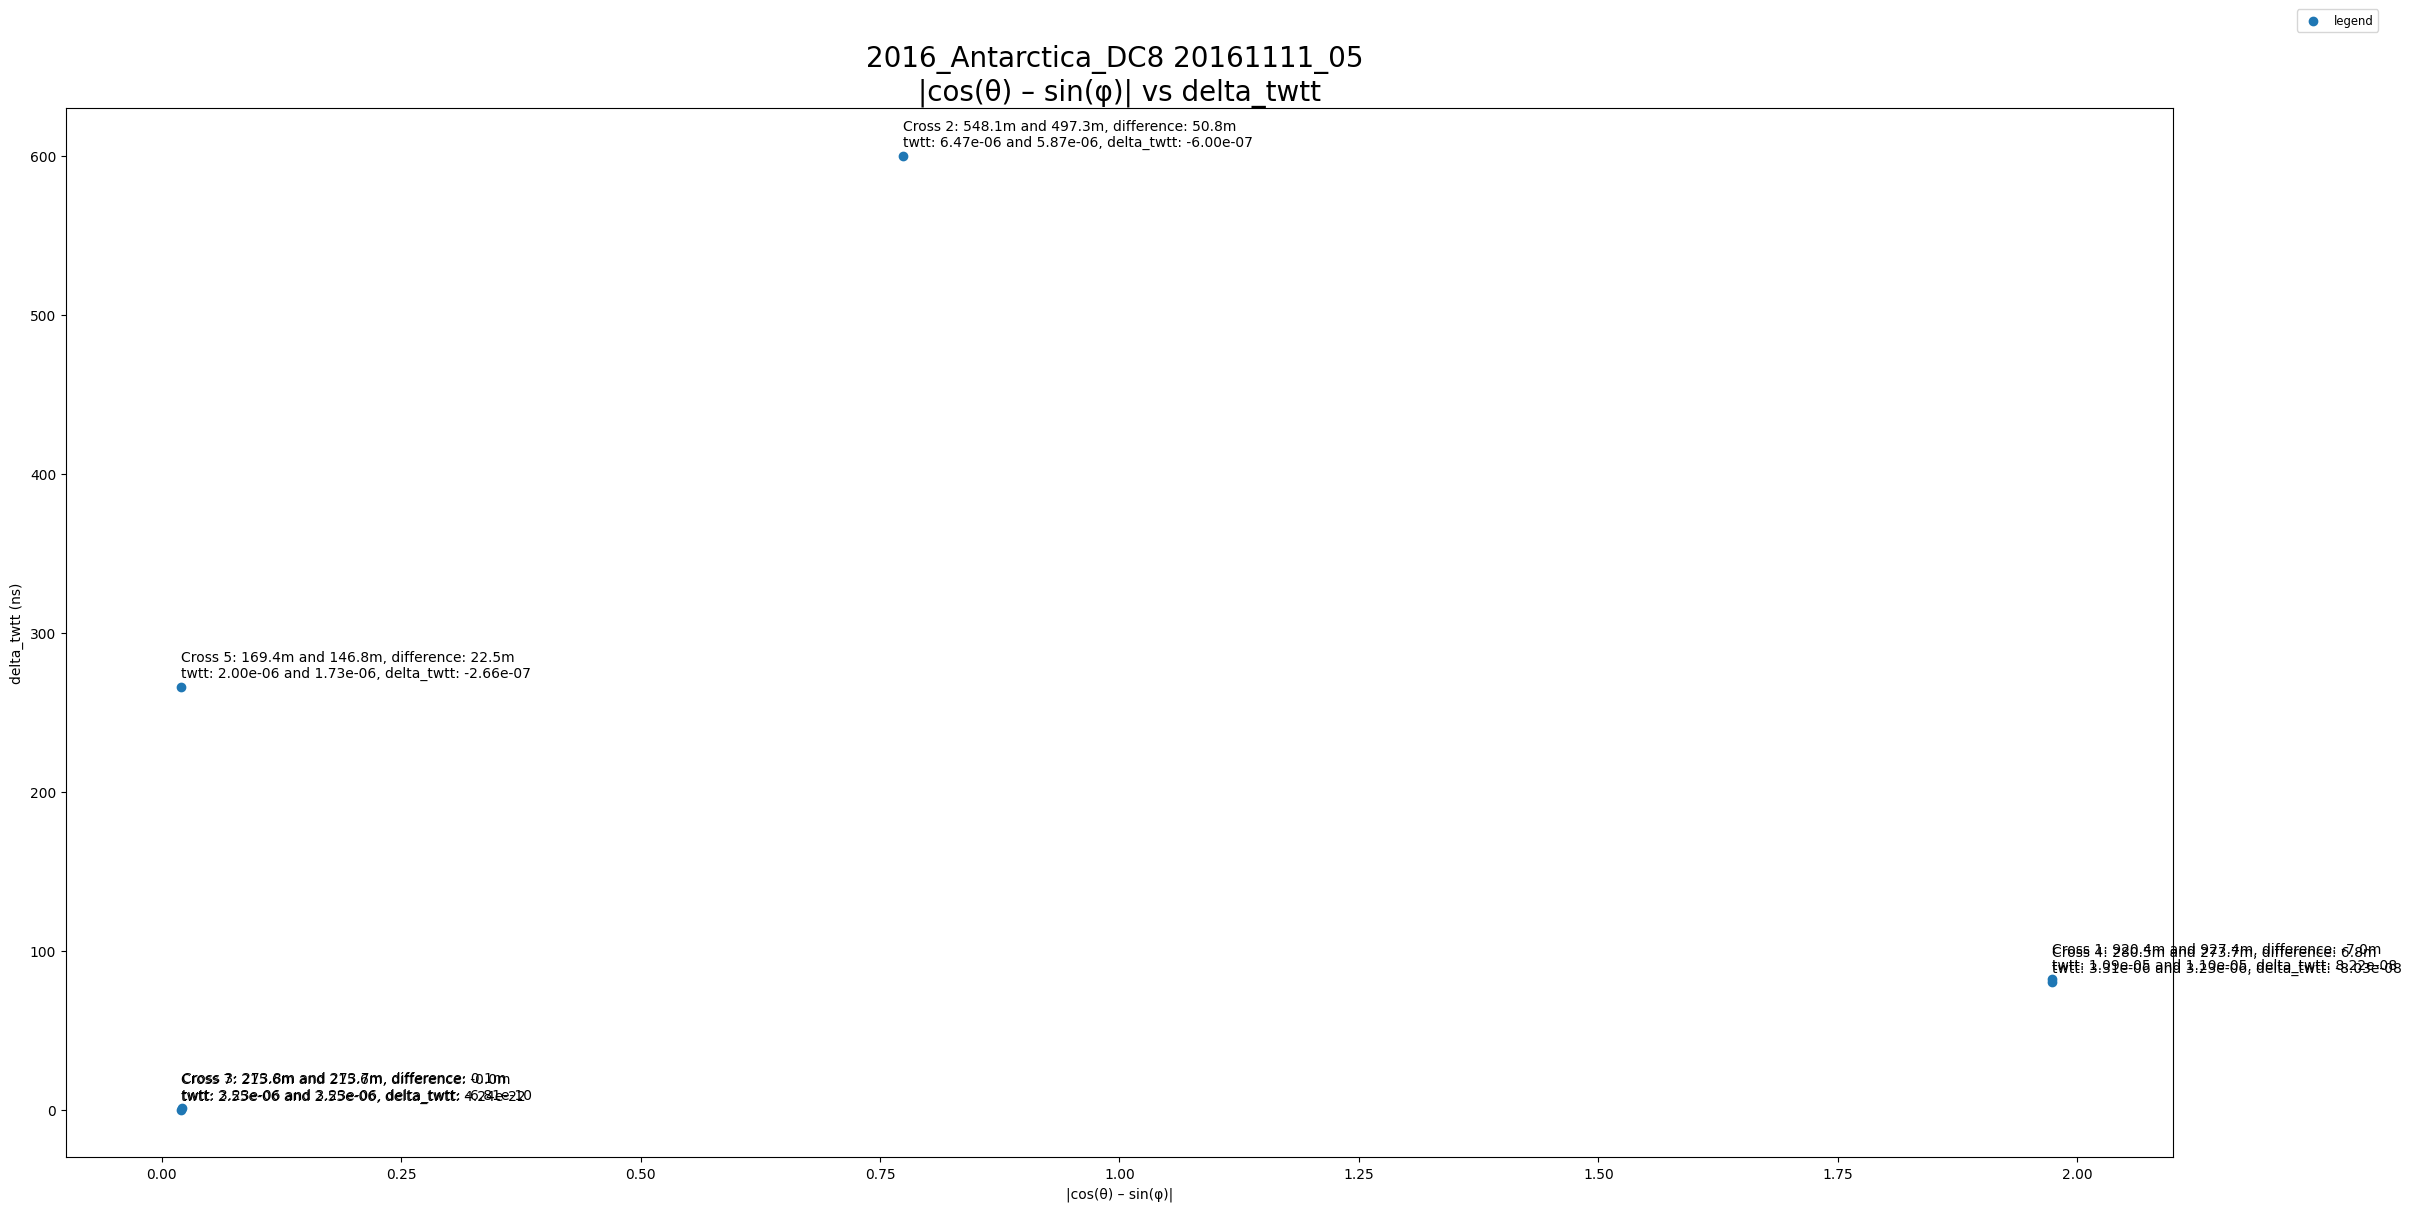

saved plot as C:\Users\rj\Documents\cresis_project\screens\2016_Antarctica_DC8_20161111_05_cos_angle_heading_vs_delta_twtt.png


In [19]:
# TODO: verify this plot is correct
# TODO: verify the Y scale and label it
    # Dave expects the delta_twtt to be ~55ns per his previous measurements
    # I am getting ~550ns for delta_twtt
    
micro = False
print_time = True

# plot delta_twtt vs |cos(angle - heading) - sin(angle - heading)| * |magnitude|  for each crossover point
plt.figure(figsize=(24, 12), layout='constrained')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 1')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_2)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 2')

# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# cos(angle - heading) vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # flow angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(angle - heading) - sin(angle - heading) |vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(θ) – sin(φ)| vs delta_twtt. theta is the angle between the flow vector and the plane heading on segment 1, phi is the angle between the plane headings on segments 1 and 2
xdata = []
ydata = []
for i in range(len(delta_twtt)):
    theta = angle[i]
    phi = abs(plane_heading_1[i] - plane_heading_2[i])
    # print(f"theta: {theta}, phi: {phi} for index: {index}\n cos(theta): {np.cos(np.radians(theta))}, sin(phi): {np.sin(np.radians(phi))}")
    # plt.scatter(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), delta_twtt[index], label='segment 1')  # angle - heading   
    delta_twtt_micros = delta_twtt[i] * 1e6
    delta_twtt_ns = delta_twtt[i] * 1e9
    
    xdata = np.append(xdata, np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))))  # |cos(θ) – sin(φ)|
    # xdata.append(np.cos(np.radians(theta)) - np.abs(np.sin(np.radians(phi))))  # cos(θ) – |sin(φ)| <- this is the same as above except negative
    # xdata.append(np.cos(np.radians(theta)) - np.sin(np.radians(phi)))  # cos(θ) – sin(φ)
    if micro:    
        delta_twtt_unit = delta_twtt_micros  # delta_twtt (µs)
        if print_time: 
            print("Using microseconds")
            print_time = False
    else:
        delta_twtt_unit = delta_twtt_ns  # delta_twtt (ns)
        if print_time: 
            print("Using nanoseconds")
            print_time = False
            
    ydata = np.append(ydata, delta_twtt_unit)

# print(f"ydata: {ydata}")
# print(f"ydata[1]: {ydata[1]}")

# print(f"depth[1]: {depth[1]}")

y_label_offset = max(ydata) * .01
for i in range(len(xdata)):
    # plt.text(xdata[index], ydata[index] + y_label_offset, f"Cross {index+1}: {depth[index]:.1f}m", fontsize=10)
    plt.text(xdata[i], ydata[i] + y_label_offset, f"Cross {i+1}: {depth1[i]:.1f}m and {depth2[i]:.1f}m, difference: {depth1[i] - depth2[i]:.1f}m\ntwtt: {twtt[i][0]:.2e} and {twtt[i][1]:.2e}, delta_twtt: {twtt[i][1] - twtt[i][0]:.2e}", fontsize=10)
    # plt.text(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), ydata[index], f"{depth[index]}", fontsize=10)
 
    # add a label with the depth of the crossover point near the point
    # try: 
        # plt.text(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), delta_twtt[index], f"{depth[index]:.2f}", fontsize=10)
        # plt.text(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), delta_twtt[index], f"{depth[index]}", fontsize=10)
    # except:
    #     print(f"error at {index}")
    #     print(f"type of theta: {type(theta)}")
    #     print(f"type of phi: {type(phi)}")
    #     print(f"type of depth: {type(depth[index])}")
        
# print(f"xdata: {xdata}")
plt.scatter(xdata,ydata)

# for each point, print the index and the delta_twtt
# for index in range(len(delta_twtt)):
#     plt.text(np.abs(np.cos(np.radians(np.array(flow_heading[index]) - np.array(plane_heading_1[index])))), delta_twtt[index], f"{index}: {delta_twtt[index]}")

# plt.xlabel(" |cos(angle - heading)| * |velocity|")
# plt.xlabel(" |cos(angle - heading)|")
plt.xlabel("|cos(θ) – sin(φ)|")

# plt.title(" |cos(angle - heading)| vs delta_twtt")
# plt.title(f"{season} {flight} \n|cos(angle - heading)| vs delta_twtt", fontsize=20)
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)


# get the current directory
dir = os.getcwd()

# if micro:
    # plt.ylim(1 * 10 ** -16, 1.1 * abs(max(ydata))) # setting the low bound to 0 caused a warning. Apparently 0 is a negative number.
    # plt.ylabel("delta_twtt (µs)")
# else:
    # plt.ylim(1 * 10 ** -16, 1.1 * abs(max(ydata))) # setting the low bound to 0 caused a warning. Apparently 0 is a negative number.
    # plt.ylabel("delta_twtt (ns)")
plt.ylabel("delta_twtt (ns)")

    
plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))
# scale axes to be logarithmic
# plt.xscale('log')
plt.yscale('log')
    
# print(f"abs(max(delta_twtt)): {abs(max(delta_twtt))}")
# set the x bounds to -0.1 to 2.1
plt.xlim(-0.1, 2.1)

# save the plot as a png file with a high dpi named after the season and flight
# plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)

# set the y max to 1.1 * the max delta_twtt




plt.yscale('linear')
# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"{dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {dir}\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt.png")
# |cos(90) - sin(90)| = 0 - 1 = 1
# plot should peak either at 1 or 0 depending on which flight is closer to the flow vector
    # in theory it should be around 1 but it could be 0 if coded wrong

# END OF RELEVANT CODE FOR ARA TALK

In [20]:
# x_data = np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1))))
# y_data = delta_twtt
# 
# # Define the Gaussian function
# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
# 
# # Initial parameter guesses: amplitude close to your data's scale, mean around the center, and a reasonable stddev
# initial_guesses = [1e-8, 0.5, 0.1]
# 
# # Use curve_fit to fit the Gaussian function to your data
# popt, pcov = opt.curve_fit(gaussian, x_data, y_data, p0=initial_guesses, maxfev=5000)
# 
# # Plot the original data
# plt.scatter(x_data, y_data, label='Data')
# 
# # Plot the fitted curve
# x_fit = np.linspace(min(x_data), max(x_data), 1000)
# y_fit = gaussian(x_fit, *popt)
# plt.plot(x_fit, y_fit, color='red', label='Fitted curve')
# 
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Gaussian Fit to Data')
# plt.legend()
# plt.show()

ntuple-ize
    cos(heading-flow)
    difference in theta paralell and perpindicular
    delta_twtt
    v_flow
- stop selecting for angle in upper cells, we can cut the data once we have it

ARA meeting in March Columbus
- talk to Kiet about how he is setting up travel

In [21]:
heading = []
# for each plane heaading, add [plane_heading_1, plane_heading_2] to the heading list
for i in range(len(plane_heading_1)):
    heading.append([plane_heading_1[i], plane_heading_2[i]])

In [22]:
print(flow_xy)

[[10.913677, -7.507326], [0.44926637, -7.954374], [15.136029, -33.866375], [8.765734, -10.68104], [0.44040224, -3.1716652], [-18.466417, -0.16398089], [-4.5085034, 16.79603]]


In [23]:
# # save the posit to a json file
# import json
# 
# filename = f"{season}_crossover_data.json"
# 
# # check to see if the file exists and if it does, load the data from it, otherwise append the data to a new file
# try:
#     with open(filename, 'r') as file:
#         data = json.load(file)
#         print(f"File {filename} exists. Loading data from file...")
# except FileNotFoundError:
#     print(f"File {filename} does not exist. Creating a new file...")
#     data = []
#     
# # if the data is not already in the file, append the data to the file
# if data:
#     print(f"Data already in file {filename}.")
# else:
#     print(f"Appending data to file {filename}...")
#     data.append({
#         "season": season,
#         "flight": flight,
#         "intersection_points": intersection_points,
#         "twtt": twtt,
#         "delta_twtt": delta_twtt,
#         "ice flow vectors (m/yr, in xy)": flow,
#         "ice flow angle": angle,
#         "ice flow magnitude": magnitude,
#         "plane heading": heading
#     })
#     with open(filename, 'w') as file:
#         json.dump(data, file)
#     print(f"Data successfully appended to file {filename}.")
# 
# 
# # TODO: convert flow vector and angle to EPSG:4326

### vector to heading dev below, DELETE WHEN FUNCTIONAL

In [24]:
def nearest_flow_to_latlon(lat, lon, iceflow_data, print_point=False):
    """
    :param lat: the latitude of the point
    :param lon: the longitude of the point
    :param iceflow_data: the iceflow data
    :return: the nearest flow vector to the lat-lon point available in the iceflow data 
    """
    # find the nearest x and y values in the iceflow data
    x, y = latlon_to_xy(lat, lon)
    x, y = find_nearest_unmasked_x_and_y(x, y, iceflow_data, max_radius=1000)
    if print_point:
        print(f"Nearest point to lat-lon: {xyindex_to_latlon(x, y)} or {x, y} in EPSG:3031")
    flow = flow_at_x_y_index(x, y, iceflow_data)
    return flow

In [25]:
intersect_x = intersection_points[0][0]
intersect_y = intersection_points[0][1]
print(f"Intersection lat-lon:\n{intersect_x, intersect_y}")
print("----------------------\n")

x, y = latlon_to_xy(intersect_x, intersect_y)
print(f"x, y of intersection before index conversion \nx: {x}, y: {y}\n")

x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"converted to indices:\nx_index: {x_index}, y_index: {y_index}\n")
x_lat, y_lat = xyindex_to_latlon(x_index, y_index)
print(f"lat-lon of indices: \n{x_lat, y_lat}\n")

difference_lat = intersect_x - x_lat
difference_lon = intersect_y - y_lat
print(f"difference in lat-lon: \n{difference_lat, difference_lon}\n")
# So the conversion functions work

Intersection lat-lon:
(-73.7632588721876, -75.64877563840822)
----------------------

x, y of intersection before index conversion 
x: -1720178.102832574, y: 440106.09221575054

converted to indices:
x_index: 2401, y_index: 5245

lat-lon of indices: 
(-73.76570467429482, -75.64674143708142)

difference in lat-lon: 
(0.002445802107217787, -0.0020342013268077608)



### TODO: fix the find nearest functions

In [26]:
def xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10, printout=False):
    """
    Find the nearest x and y value in the iceflow data to an input x and y value.
    """
    # iterate through every data point within the max_radius of the input x and y and save the xy pairs of any unmasked data
    x = x_to_index(x)
    y = y_to_index(y)
    unmasked = []
    for x_iterator in range(x - max_radius, x + max_radius):
        for y_iterator in range(y - max_radius, y + max_radius):
            if (
                    0 <= x_iterator < iceflow_data[2].shape[0]  # if the x index is within the bounds of the iceflow data
                    and 0 <= y_iterator < iceflow_data[2].shape[1]
                    and not np.ma.is_masked(iceflow_data[2][x_iterator][y_iterator])
                    and not np.ma.is_masked(iceflow_data[3][x_iterator][y_iterator])
            ):
                unmasked.append((x_iterator, y_iterator))
            if printout and not np.ma.is_masked(iceflow_data[2][x_iterator][y_iterator]):
                print(f"unmasked x: {x_iterator}, unmasked y: {y_iterator}")
                print(f"unmasked lat: {iceflow_data[4][x_iterator][y_iterator]}, unmasked lon: {iceflow_data[5][x_iterator][y_iterator]}")
                print(f"unmasked flow: {iceflow_data[2][x_iterator][y_iterator]}, {iceflow_data[3][x_iterator][y_iterator]}")
    # find the xy pair with the minimum distance from the input x and y
    min_distance = 100
    min_x = None
    min_y = None
    for x_iterator, y_iterator in unmasked:
        distance = math.sqrt((x - x_iterator) ** 2 + (y - y_iterator) ** 2)
        if distance < min_distance:
            min_distance = distance
            min_x = x_iterator
            min_y = y_iterator
    # TODO: figure out why these are indices and not x and y
        # it works fine, they just are.
    return min_x, min_y

In [27]:
lat = intersection_points[0][0]
lon = intersection_points[0][1]
print(f"lat: {lat}, lon: {lon}")

x, y = latlon_to_xy(lat, lon)
print(f"x: {x}, y: {y}")

x_index, y_index = x_to_index(x), y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")

# nearest_x_index, nearest_y_index = depracated: find_nearest_unmasked_x_and_y(x, y, iceflow_data, max_radius=1000)

nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)

print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")
print(f"flow at nearest: {iceflow_data[2][nearest_x_index][nearest_y_index]}, {iceflow_data[3][nearest_x_index][nearest_y_index]}")

lat: -73.7632588721876, lon: -75.64877563840822
x: -1720178.102832574, y: 440106.09221575054
x_index: 2401, y_index: 5245
nearest_x_index: 2401, nearest_y_index: 5245
nearest_lat: -73.76954927885168, nearest_lon: 345.6548862310431
flow at nearest: 10.913677215576172, -7.507326126098633


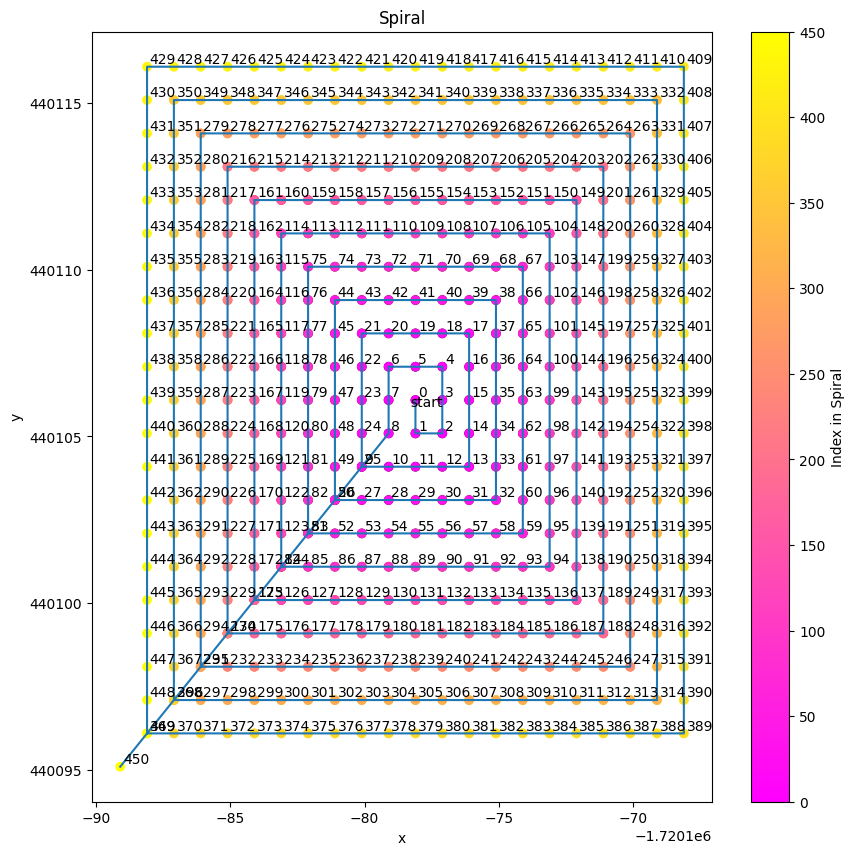

In [28]:
# plot the spiral around the point
plot_spiral(x,y, 10)

### Move to an example notebook when done. Shows how the xy to index conversion works

In [29]:
#print x min and max
min = np.min(iceflow_data[0])
max = np.max(iceflow_data[0])

print(f"min: {min}, max: {max}")

print(f"min/450: {min/450}, max/450: {max/450}")

one, two, three = (iceflow_data[1][0], iceflow_data[1][1], iceflow_data[1][2])
print(f"one: {one}, two: {two}, three: {three}")
print(f"one - two: {one - two}, two - three: {two - three}")

min: -2800000.0, max: 2799800.0
min/450: -6222.222222222223, max/450: 6221.777777777777
one: 2800000.0, two: 2799550.0, three: 2799100.0
one - two: 450.0, two - three: 450.0


In [30]:
def x_to_index(x):
    return 6223 + int(x/450)
def y_to_index(y):
    return 6223 - int(y/450)
def index_to_x(x):
    return (x - 6223) * 450
def index_to_y(y):
    return (6223 - y) * 450

In [31]:
def xyindex_vector_to_heading(x_index, y_index, x_vector, y_vector):
    """
    This function is used to convert an x and y vector in EPSG:3031 to a heading in EPSG:4326.
    :param x_index: the x coordinate
    :param y_index: the y coordinate
    :param x_vector: the x vector
    :param y_vector: the y vector
    :return: the heading in EPSG:4326
    """
    # convert the x and y coordinates to lat and lon
    lat, lon = xyindex_to_latlon(x_index, y_index)
    # convert the x and y vector to lat and lon
    lat_vector, lon_vector = xyindex_to_latlon(x_index + x_vector, y_index + y_vector)
    # calculate the heading
    geodesic = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geodesic.inv(lon, lat, lon_vector, lat_vector)
    return angle1, angle2, distance



# TODO: ~~take some plane vectors, convert the relevant points to xy, then run them through the heading function to see if it works compared to the plane heading~~
- I think this works now

In [32]:
# for testing purposes only, delete when done
def find_heading_test(lat1, lon1, lat2, lon2):
    # print the lat-lon points
    # print(f"lat-lon input to find_heading:"
    #       f"\n({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    # lon = layer.lon[index]
    # lat = layer.lat[index]
    # lon1 = layer.lon[index - window_size]
    # lat1 = layer.lat[index - window_size]
    # lon2 = layer.lon[index + window_size]
    # lat2 = layer.lat[index + window_size]

    print(f"lat-lons determined by find_heading:"
          f"\n({lat1}, {lon1}), ({lat2}, {lon2})")
    # delta_lon1 = lon - lon1
    # delta_lat1 = lat - lat1
    # delta_lon2 = lon2 - lon
    # delta_lat2 = lat2 - lat
    # print(f"delta_lon1: {delta_lon1}, delta_lat1: {delta_lat1}, delta_lon2: {delta_lon2}, delta_lat2: {delta_lat2}")
    fwd_azimuth, back_azimuth, distance = geodesic.inv(lon1, lat1, lon2, lat2)
    return fwd_azimuth

In [33]:
def find_heading_points(layer, index, window_size=100):
    """
    :param layer: a Layer object
    :param index: the index of the point in the layer
    :param window_size: the number of points to use in the slope calculation
    :return: the bearing of the current that flew through the points.
    This has nothing to do with the slope of the layer. only the lat-lon points.
    """
    # print the lat-lon points
    print(f"lat-lon input to find_heading:"
          f"\n\t({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    lon = layer.lon[index]
    lat = layer.lat[index]
    lon1 = layer.lon[index - window_size]
    lat1 = layer.lat[index - window_size]
    lon2 = layer.lon[index + window_size]
    lat2 = layer.lat[index + window_size]
    
    return lon1, lat1, lon2, lat2

In [34]:
# TODO: when this works, udpate the original code cell to use the non test versions of the iceflow heading function
# TODO, the iceflow heading finder doesn't work on too close of data because they show up as the same index in the iceflow data.
    # put in some larger fake lat-lons to test both
    # how was it working before then?
        # the flow vector comes from the data so it works
magnitude = []
plane_heading_1 = []
plane_heading_2 = []
# for index in range(len(intersect_indices)):
for i in range(1):
    # find the heading of the first segment
    test_lat1 = -81.1 
    test_lon1 = -29.7
    test_lat2 = -81.2
    test_lon2 = -29.8
    plane_heading_1.append(find_heading_test(test_lat1, test_lon1, test_lat2, test_lon2))
    print(f"heading_1[{i}]: {plane_heading_1[i]}")
    
    print("**************")

    # convert the test lat-lon points to xy
    x1, y1 = latlon_to_xy(test_lat1, test_lon1) 
    x2, y2 = latlon_to_xy(test_lat2, test_lon2)
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    
    # convert the xy points to indices
    x1_index = x_to_index(x1)
    y1_index = y_to_index(y1)
    x2_index = x_to_index(x2)
    y2_index = y_to_index(y2)
    print(f"x1_index: {x1_index}, y1_index: {y1_index}, x2_index: {x2_index}, y2_index: {y2_index}")
    
    # TODO: should this be a vector of indices or x and y? x and y sounds right but it errors out on index overflow. Have to go to class so can't look right now. Does the xy_vector function use indices or x and y? 
        # the vector_to_heading() function uses indices for some reason but it works so I'mma let it ride
    vector = [x2_index - x1_index, y2_index - y1_index]
    # vector = [x2 - x1, y2 - y1]

    # convert the vector to a heading
    heading = xyindex_vector_to_heading(x1_index, y1_index, vector[0], vector[1])
    
    print(f"heading by way of iceflow functions: \n{heading}")
    
    
    
    print(section_break)
    
    


lat-lons determined by find_heading:
(-81.1, -29.7), (-81.2, -29.8)
heading_1[0]: -171.30175278944094
**************
x1: -480038.6130697499, y1: 841597.279504398, x2: -476075.96804035176, y2: 831275.5006125587
x1_index: 5157, y1_index: 4353, x2_index: 5166, y2_index: 4376
heading by way of iceflow functions: 
(-171.68459747910515, 8.410421431016317, 11357.335327564973)
--------------------


In [35]:
# calculate the twtt to depth conversion for 10, 20, ..., 100 microseconds

twtt = np.arange(10, 110, 10) * 1e-6
depth = twtt_to_depth(twtt, refractive_index=1.77)

# for each twtt, print the twtt in microseconds and the depth in meters. both should be rounded to 0 decimal places
print(f"twtt to depth conversion for refractive index 1.77:")
for i in range(len(twtt)):
    print(f"{twtt[i] * 1e6:.0f} {chr(956)}s:\t{depth[i]:.0f} meters")

twtt to depth conversion for refractive index 1.77:
10 μs:	847 meters
20 μs:	1694 meters
30 μs:	2541 meters
40 μs:	3387 meters
50 μs:	4234 meters
60 μs:	5081 meters
70 μs:	5928 meters
80 μs:	6775 meters
90 μs:	7622 meters
100 μs:	8469 meters
